In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, UniformTriRefiner, CubicTriInterpolator

In [2]:
def dipole_potential(x, y):
    """the electric dipole potential V, at position *x*, *y*."""
    r_sq = x ** 2 + y ** 2
    theta = np.arctan2(y, x)
    z = np.cos(theta) / r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))

In [3]:
n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

In [4]:
angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

In [5]:
x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
v = dipole_potential(x, y)

In [6]:
# create the Triangulation; no triangles specified so Delaunay triangulation created
triang = Triangulation(x, y)

# mask off unwanted triangles
triang.set_mask(
    np.hypot(
        x[triang.triangles].mean(axis=1), y[triang.triangles].mean(axis=1)
    ) < min_radius
)

In [7]:
# refine data - interpolates the electrical potential v
refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(v, subdiv=3)

# computes the electrical field (ex, ey) as gradient of electrical potential
tci = CubicTriInterpolator(triang, -v)
# gradient requested here at the mesh nodes but could be anywhere else
ex, ey = tci.gradient(triang.x, triang.y)
e_norm = np.sqrt(ex ** 2 + ey ** 2)

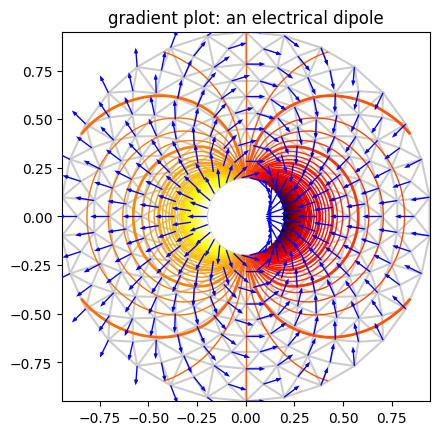

In [8]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
# enforce the margins, and enlarge them to give room for the vectors
ax.set_sticky_edges = False
ax.margins(0.07)

ax.triplot(triang, color="0.8")
levels = np.arange(0.0, 1.0, 0.01)
ax.tricontour(
    tri_refi, z_test_refi, levels=levels, cmap="hot",
    linewidths=[2.0, 1.0, 1.0, 1.0],
)

# plots direction of the electrical vector field
ax.quiver(
    triang.x, triang.y, ex / e_norm,ey / e_norm,
    units="xy", scale=10.0, zorder=3, color="blue",
    width=0.007, headwidth=3.0, headlength=4.0,
)

ax.set_title("gradient plot: an electrical dipole")
plt.show()